We work with a dataset containing 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative).  In addition, there are another 50,000 IMDB reviews provided without any rating labels.  

The reviews are split evenly into train and test sets (25k train and 25k test). The overall distribution of labels is also balanced within the train and test sets (12.5k pos and 12.5k neg).  Our goal is to see how well we can predict sentiment in the test dataset. 

In [41]:
import os                           # for accessing directory of files
import pandas as pd                 # for importing the data
from bs4 import BeautifulSoup       # for removing HTML tags
import re                           # for processing with regular expressions
import nltk.data                    # for sentence splitting
import logging                      # output messages for word2vec embedding step
from gensim.models import word2vec  # embedding algorithm
import numpy as np
import tensorflow as tf
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt, mpld3
%matplotlib inline

# If you are using Python 3, you will get an error.
# (Pattern is a Python 2 library and fails to install for Python 3.)

The dataset can be downloaded [here](http://ai.stanford.edu/~amaas/data/sentiment/).  We first write code to extract the reviews into appropriate Pandas dataframes.  We also record the sentiment of the review, when it is available.

In [2]:
def load_data(directory_name):
    data = []
    files = [f for f in os.listdir('../../../aclImdb/' + directory_name)]
    for f in files:
        with open('../../../aclImdb/' + directory_name + f, "r", encoding = 'utf-8') as myfile:
            data.append(myfile.read())
    df = pd.DataFrame({'review': data, 'file': f})
    return df

def add_sentiment(df, sentiment):
    df = df.join(pd.DataFrame({'sentiment': sentiment*np.ones(df.size)}))
    return df

`train_pos`, `train_neg`, `test_pos`, `test_neg`, and `unsup` are Pandas dataframes.  They have either two or three columns, taken from the following potential set of columns:
- `sentiment` $\in \{0,1\}$ : indicates pos (1) or neg (0) sentiment
- `file` : name of file that contains review
- `review` : the full text of the review

In [3]:
# load training dataset
train_pos = load_data('train/pos/')
train_pos = add_sentiment(train_pos, 1)

train_neg = load_data('train/neg/')
train_neg = add_sentiment(train_neg, 0)

# load test dataset
test_pos = load_data('test/pos/')
test_pos = add_sentiment(test_pos, 1)

test_neg = load_data('test/neg/')
test_neg = add_sentiment(test_neg, 0)

# load unsupervised dataset
unsup = load_data('train/unsup/')

Next, we ensure that the dataset was downloaded properly, by counting the total number of reviews of each type.

In [4]:
print("\n %d pos train reviews \n %d neg train reviews \n %d pos test reviews \n %d neg test reviews \n %d unsup reviews" \
      % (train_pos.shape[0], train_neg.shape[0], test_pos.shape[0], test_neg.shape[0], unsup.shape[0]))
print(" \n TOTAL: %d reviews" % int(train_pos.shape[0] + train_neg.shape[0] + test_pos.shape[0] + test_neg.shape[0] + unsup.shape[0]))


 12500 pos train reviews 
 12500 neg train reviews 
 12500 pos test reviews 
 12500 neg test reviews 
 50000 unsup reviews
 
 TOTAL: 100000 reviews


We would like to process each review to make it mathematically digestible.  

We will convert each review into a list of lists (specifically, a list of sentences, each one a list of words).

We split a paragraph into sentences through the use of NLTK's `punkt` tokenizer.  As an example, we print the first sentence identified by `punkt` in the review above.  It nicely corresponds to our expectations!

Now, we create a function (here, `review_to_sentences`) that puts everything together by looping through the paragraph and creates lists of lists of clean sentences.

We now write code that converts an individual sentence into a list of words.  But we also need each sentence to be cleaned.  There are HTML tags such as `<br/>`, abbreviations, punctuation - all common issues when processing text from online. We need to tidy up the text before applying machine learning algorithms.

Our function `raw_sentence_to_wordlist` works as follows:
- HTML tags are removed through the use of the Beautiful Soup library.
- Numbers and punctuation are replaced with a space using regular expressions.
- We convert all of the words to lowercase and convert the sentence string into a list of words.

In [5]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def clean_str(string):
    # Function that cleans text using regular expressions
    string = re.sub(r' +', ' ', string)
    string = re.sub(r'\.+', '.', string)
    string = re.sub(r'\.(?! )', '. ', string)    
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'m", " \'m", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " ( ", string) 
    string = re.sub(r"\)", " ) ", string) 
    string = re.sub(r"\?", " ? ", string) 
    string = re.sub(r"\.", " . ", string)
    string = re.sub(r"\-", " - ", string)
    return string

# Define a function to split a review into parsed sentences
def review_to_word_list( review, tokenizer ):
    # Function to turn each review into a list of sentences, 
    # where each sentence is a list of words
    #
    # 1. Process punctuation, excessive periods, missing spaces 
    review = clean_str(review)
    #
    # 2. Remove HTML tags 
    review = BeautifulSoup(review, "lxml").get_text()
    #
    # 3. Use the NLTK tokenizer to split the review into list of sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 4. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is not long enough, skip it
        raw_sentence = raw_sentence.lower().split()
        if len(raw_sentence) > 1:
            # add processed list of words (getting rid of extra spaces at front/back)
            sentences.append( raw_sentence )
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [6]:
def corpus_to_list(df, tokenizer):
    # Turns dataframe of reviews into a list of sentences,
    # where each sentence is a list of words
    # and sentences are derived from *all reviews* in dataframe df
    sentences = []
    for idx in tqdm(df.index):
        to_append = review_to_word_list(df.ix[idx, 'review'], tokenizer)
        sentences += to_append
    return sentences

In [7]:
train_pos_sentences = corpus_to_list(train_pos, tokenizer)
train_neg_sentences = corpus_to_list(train_neg, tokenizer)
test_pos_sentences = corpus_to_list(test_pos, tokenizer)
test_neg_sentences = corpus_to_list(test_neg, tokenizer)
unsup_sentences = corpus_to_list(unsup, tokenizer)

100%|██████████| 50000/50000 [00:51<00:00, 977.03it/s] 


In [8]:
def extreme_sentences(sentences):
    # prints shortest and longest sentence in a list (sentences)
    (tmp, longest_sentence) = max(enumerate(sentences), key = lambda sentences: len(sentences[1]))   
    (tmp, shortest_sentence) = min(enumerate(sentences), key = lambda sentences: len(sentences[1]))
    print("The longest sentence has %s words." % len(longest_sentence))
    print("The shortest sentence has %s words." % len(shortest_sentence))
    print(longest_sentence)
    print("Shortest sentence:", shortest_sentence, '\n')

In [9]:
all_sentences = ['train_pos_sentences', 'train_neg_sentences', 'test_pos_sentences', 'test_neg_sentences', 'unsup_sentences']
for i in all_sentences:
    print("Extreme sentence statistics for " + i + ":")
    extreme_sentences(eval(i))

Extreme sentence statistics for train_pos_sentences:
The longest sentence has 267 words.
The shortest sentence has 2 words.
['it', "'s", 'a', 'genuine', 'shame', 'that', 'this', 'spin', '-', 'off', 'tv', 'series', 'inspired', 'by', 'the', 'superior', 'made', '-', 'for', '-', 'tv', 'pictures', '"the', 'night', 'stalker"', 'and', '"the', 'night', 'strangler"', 'only', 'lasted', 'a', 'single', 'season', 'and', 'twenty', 'episodes', ',', 'because', 'at', 'its', 'best', 'this', 'program', 'offered', 'an', 'often', 'winning', 'and', 'highly', 'entertaining', 'blend', 'of', 'sharp', 'cynical', 'humor', '(', 'carl', 'kolchak', "'s", 'spirited', 'verbal', 'sparring', 'matches', 'with', 'perpetually', 'irascible', 'and', 'long', '-', 'suffering', 'editor', 'tony', 'vincenzo', 'were', 'always', 'a', 'treat', 'to', 'watch', 'and', 'hear', ')', ',', 'clever', 'writing', ',', 'nifty', 'supernatural', 'menaces', '(', 'gotta', 'love', 'the', 'offbeat', 'and', 'original', 'creatures', 'in', '"the', 'sp

Total number of sentences: 1322524
Sentences of length 0: 36340
Sentences of length >200: 69 ( 0.005217296623728568 %,  <=200: 1322455 )

Sentences of length >100: 1581 ( 0.11954414437847631 %,  <=100: 1320943 )

Sentences of length >60: 18159 ( 1.3730563679751748 %,  <=60: 1304365 )



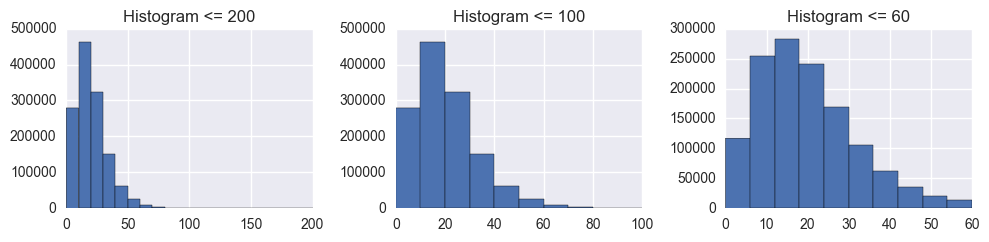

In [10]:
# obtain list of sentence lengths
sentences = train_pos_sentences + train_neg_sentences + test_pos_sentences + test_neg_sentences + unsup_sentences
sentence_lengths = [len(elem) for elem in sentences]
sentence_lengths.sort()

# get total number of sentences
print("Total number of sentences:", len(sentence_lengths))
# get number of sentences of length 2
print("Sentences of length 0:", sum([i==2 for i in sentence_lengths]))
# get number of sentences of size greater than 200
print("Sentences of length >200:", sum([i>200 for i in sentence_lengths]), 
      "(", 100*sum([i>200 for i in sentence_lengths])/len(sentence_lengths), "%, ",
      "<=200:", sum([i<=200 for i in sentence_lengths]), ")\n")
# get number of sentences of size greater than 100
print("Sentences of length >100:", sum([i>100 for i in sentence_lengths]),
      "(", 100*sum([i>100 for i in sentence_lengths])/len(sentence_lengths), "%, ",
      "<=100:", sum([i<=100 for i in sentence_lengths]), ")\n")
# get number of sentences of size greater than 60
print("Sentences of length >60:", sum([i>60 for i in sentence_lengths]), 
      "(", 100*sum([i>60 for i in sentence_lengths])/len(sentence_lengths), "%, ",
      "<=60:", sum([i<=60 for i in sentence_lengths]), ")\n")

# make plots
plt.figure(figsize=(10,2.5))

# make histogram of sentence lengths for sentences <=200 
plt.subplot(131)
plt.hist(sentence_lengths, bins=np.linspace(0, 200, 21))
plt.title("Histogram <= 200")

# make histogram of sentence lengths for sentences <=100 
plt.subplot(132)
plt.hist(sentence_lengths, bins=np.linspace(0, 100, 11))
plt.title("Histogram <= 100")

# make histogram of sentence lengths for sentences <=60
plt.subplot(133)
plt.hist(sentence_lengths, bins=np.linspace(0, 60, 11))
plt.title("Histogram <= 60")

# adjust spacing between subplots to minimize the overlaps
plt.tight_layout()
plt.show()

In [11]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model 
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

2017-01-16 20:40:20,781 : INFO : collecting all words and their counts
2017-01-16 20:40:20,782 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-01-16 20:40:20,824 : INFO : PROGRESS: at sentence #10000, processed 209211 words, keeping 15798 word types
2017-01-16 20:40:20,869 : INFO : PROGRESS: at sentence #20000, processed 421396 words, keeping 23756 word types
2017-01-16 20:40:20,912 : INFO : PROGRESS: at sentence #30000, processed 630305 words, keeping 29835 word types
2017-01-16 20:40:20,957 : INFO : PROGRESS: at sentence #40000, processed 847363 words, keeping 35332 word types
2017-01-16 20:40:21,002 : INFO : PROGRESS: at sentence #50000, processed 1055695 words, keeping 39793 word types
2017-01-16 20:40:21,048 : INFO : PROGRESS: at sentence #60000, processed 1264417 words, keeping 43652 word types
2017-01-16 20:40:21,096 : INFO : PROGRESS: at sentence #70000, processed 1470994 words, keeping 47565 word types
2017-01-16 20:40:21,141 : INFO : PROGRESS: 

In [12]:
model.most_similar("awesome")

[('amazing', 0.7471208572387695),
 ('incredible', 0.6719068288803101),
 ('fantastic', 0.665031909942627),
 ('excellent', 0.6431220769882202),
 ('astounding', 0.6162066459655762),
 ('cool', 0.6125535368919373),
 ('outstanding', 0.5977039933204651),
 ('exceptional', 0.577246904373169),
 ('fabulous', 0.5752778053283691),
 ('awful', 0.5729072093963623)]

In [13]:
model.most_similar("awful")

[('terrible', 0.7523362636566162),
 ('atrocious', 0.7489367127418518),
 ('dreadful', 0.7298828363418579),
 ('abysmal', 0.7129719853401184),
 ('horrid', 0.6986831426620483),
 ('horrible', 0.6876540780067444),
 ('appalling', 0.685523509979248),
 ('horrendous', 0.6548080444335938),
 ('lousy', 0.6344122886657715),
 ('bad', 0.5880255699157715)]

In [44]:
upper_limit = 300

vocabulary = list(model.vocab.keys())[:upper_limit]
emb_tuple = tuple([model[v] for v in vocabulary])
X = np.vstack(emb_tuple)
tsne_model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
X_new = tsne_model.fit_transform(X) 

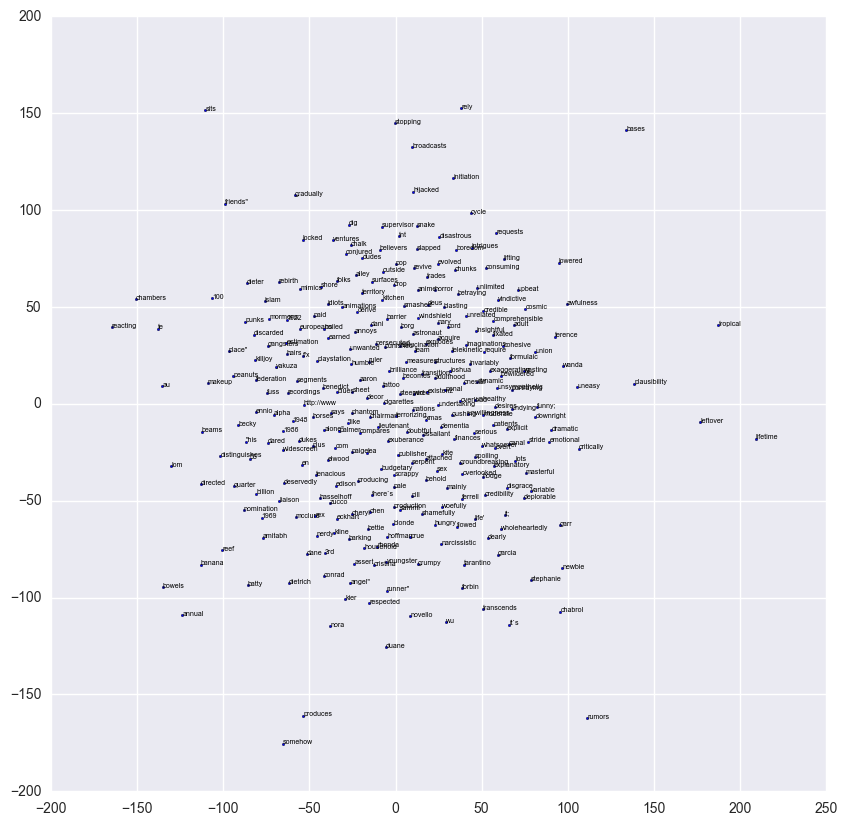

In [58]:
plt.figure(figsize=(10,10))
plt.scatter(X_new[:, 0], X_new[:, 1], s=3)
for label, x, y in zip(vocabulary, X_new[:, 0], X_new[:, 1]):
    plt.text(x, y, label, {'color': 'k', 'fontsize': 5})
mpld3.enable_notebook()